# Импорт библиотек, загрузка данных

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

import os

nltk.download('stopwords')

# Загрузка данных
csv_path = '88005553535.csv'
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(df.head())
    df.info(verbose=True)
else:
    print(f"Файл '{csv_path}' не найден.")


   annotation_id  annotator                                       comment  \
0             16          2                                       спасибо   
1             17          2                                      спасибо!   
2             18          2                                      Отлично    
3             19          2  Благодарю за оперативное решение проблемы !    
4             20          2         Прекрасный специалист! Побольше таких   

                    created_at       id  lead_time  rating  \
0  2025-05-08T12:32:06.806278Z  2945792     49.604       5   
1  2025-05-08T12:44:25.556719Z  3234340      2.058       5   
2  2025-05-08T12:44:46.429049Z  3380332     19.677       5   
3  2025-05-08T12:45:09.100228Z  3381812     21.395       5   
4  2025-05-08T12:45:23.515860Z  3461991     13.272       5   

                                           sentiment  \
0                                       Вопрос решен   
1                                       Вопрос решен

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Предварительная обработка данных

In [3]:
# Очистка и предварительная обработка текста
stop_words = set(stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Удаление спецсимволов и цифр
    text = re.sub(r'[^а-яА-ЯёЁ\s]', '', text.lower())
    # Удаление стоп-слов и стемминг
    words = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

# Применение очистки к комментариям
df['cleaned_comment'] = df['comment'].apply(clean_text)

# Извлечение меток из поля sentiment
def extract_labels(sentiment):
    if pd.isna(sentiment):
        return []
    if sentiment == "Вопрос решен":
        return ["Вопрос решен"]
    if sentiment == "ни к одному из перечисленных":
        return ["Другое"]
    if sentiment.startswith('{"choices":'):
        import json
        try:
            labels = json.loads(sentiment.replace("'", '"'))['choices']
            return [label.strip() for label in labels]
        except:
            return []
    return []

# Создание бинарных меток для каждой категории
categories = [
    "Нравится скорость отработки заявок",
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Понравилось выполнение заявки",
    "Вопрос решен",
    "Другое"
]

mlb = MultiLabelBinarizer(classes=categories)
labels = mlb.fit_transform(df['sentiment'].apply(extract_labels))

# Создание DataFrame с метками
labels_df = pd.DataFrame(labels, columns=categories)

# Добавление рейтинга как дополнительной фичи
df['rating'] = df['rating'].fillna(3)  # Заполнение пропусков средним значением

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ни к одному из перечисленных'] will be ignored
  warnings.warn(


# Разделение данных и создание пайплайна

In [4]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_comment'],
    labels_df,
    test_size=0.3,
    random_state=42
)

# Создание пайплайна с TF-IDF и классификатором
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', MultiOutputClassifier(
        LogisticRegression(max_iter=1000, class_weight='balanced', C=0.1, solver='saga'),
        n_jobs=-1
    ))
])

# Обучение модели
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(C=0.1,
                                                                    class_weight='balanced',
                                                                    max_iter=1000,
                                                                    solver='saga'),
                                       n_jobs=-1))])

# Оценка модели

In [5]:
# Предсказание на тестовых данных
y_pred_proba = pipeline.predict_proba(X_test)
y_pred = pipeline.predict(X_test)

# Вычисление ROC-AUC для каждой категории
roc_auc_scores = {}
for i, category in enumerate(categories):
    roc_auc = roc_auc_score(y_test[category], y_pred_proba[i][:, 1])
    roc_auc_scores[category] = roc_auc
    print(f"ROC-AUC for {category}: {roc_auc:.4f}")

# Средний ROC-AUC
mean_roc_auc = np.mean(list(roc_auc_scores.values()))
print(f"\nMean ROC-AUC: {mean_roc_auc:.4f}")

# Отчет по классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Проверка на переобучение
y_train_pred_proba = pipeline.predict_proba(X_train)
train_roc_auc_scores = {}
for i, category in enumerate(categories):
    roc_auc = roc_auc_score(y_train[category], y_train_pred_proba[i][:, 1])
    train_roc_auc_scores[category] = roc_auc

print("\nTrain ROC-AUC Scores:")
for category, score in train_roc_auc_scores.items():
    print(f"{category}: {score:.4f}")

# Разница между train и test ROC-AUC
print("\nOverfitting Check (Train - Test ROC-AUC):")
for category in categories:
    diff = train_roc_auc_scores[category] - roc_auc_scores[category]
    print(f"{category}: {diff:.4f}")

ROC-AUC for Нравится скорость отработки заявок: 0.9744
ROC-AUC for Нравится качество выполнения заявки: 0.9476
ROC-AUC for Нравится качество работы сотрудников: 0.8580
ROC-AUC for Понравилось выполнение заявки: 0.8545
ROC-AUC for Вопрос решен: 0.9145
ROC-AUC for Другое: 0.9784

Mean ROC-AUC: 0.9212

Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок       0.91      0.93      0.92       260
 Нравится качество выполнения заявки       0.55      0.77      0.64        48
Нравится качество работы сотрудников       0.34      0.83      0.48       121
       Понравилось выполнение заявки       0.48      0.70      0.57       129
                        Вопрос решен       0.99      0.78      0.87       627
                              Другое       0.37      0.99      0.54        67

                           micro avg       0.69      0.82      0.75      1252
                           macro avg       0.61   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Визуализация ROC-кривых

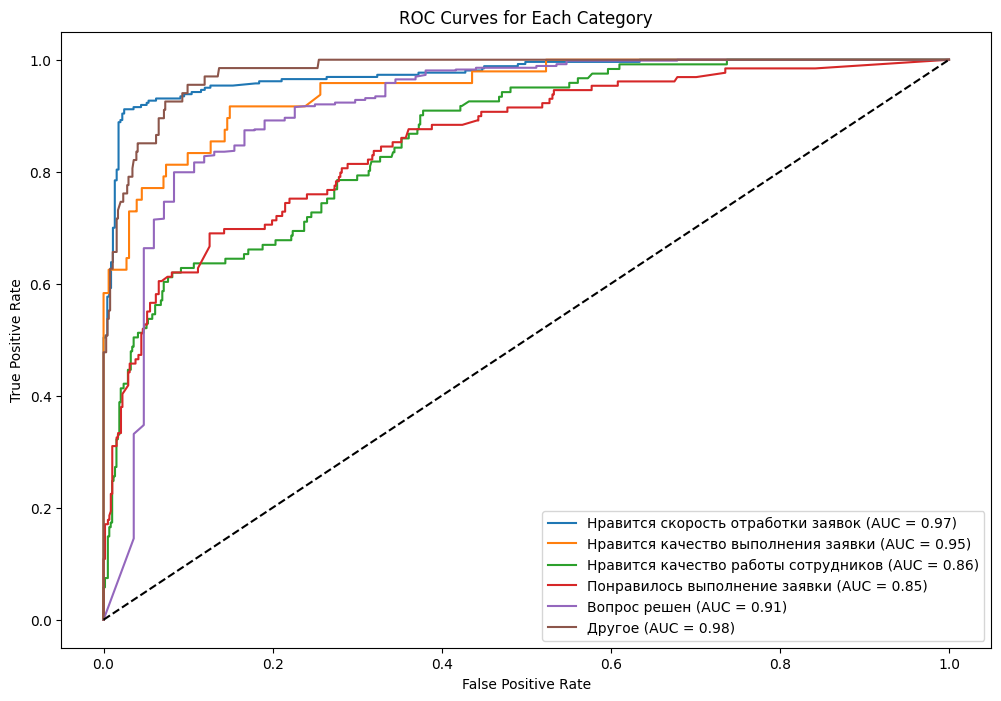

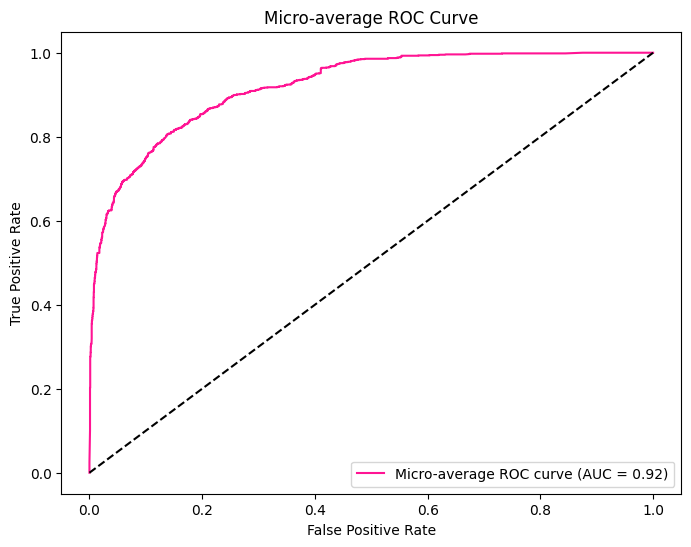

In [6]:
# ROC-кривые для каждой категории
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    fpr, tpr, _ = roc_curve(y_test[category], y_pred_proba[i][:, 1])
    plt.plot(fpr, tpr, label=f'{category} (AUC = {roc_auc_scores[category]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Category')
plt.legend(loc='lower right')
plt.show()

# Общая ROC-кривая (micro-average)
y_test_micro = y_test.values.ravel()
y_pred_proba_micro = np.vstack([y_pred_proba[i][:, 1] for i in range(len(categories))]).T.ravel()
fpr_micro, tpr_micro, _ = roc_curve(y_test_micro, y_pred_proba_micro)
roc_auc_micro = roc_auc_score(y_test_micro, y_pred_proba_micro)

plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})', color='deeppink')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()